In [1]:
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import joblib
import requests
import io

In [2]:
#url = "REPLACE-THIS-WITH-THE-URL-OF-THE-CSV-FILE" 
#download = requests.get(url).content
df  = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
df['age'].unique()

array([63, 37, 41, 56, 57, 44, 52, 54, 48, 49, 64, 58, 50, 66, 43, 69, 59,
       42, 61, 40, 71, 51, 65, 53, 46, 45, 39, 47, 62, 34, 35, 29, 55, 60,
       67, 68, 74, 76, 70, 38, 77], dtype=int64)

In [13]:
df.isna().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

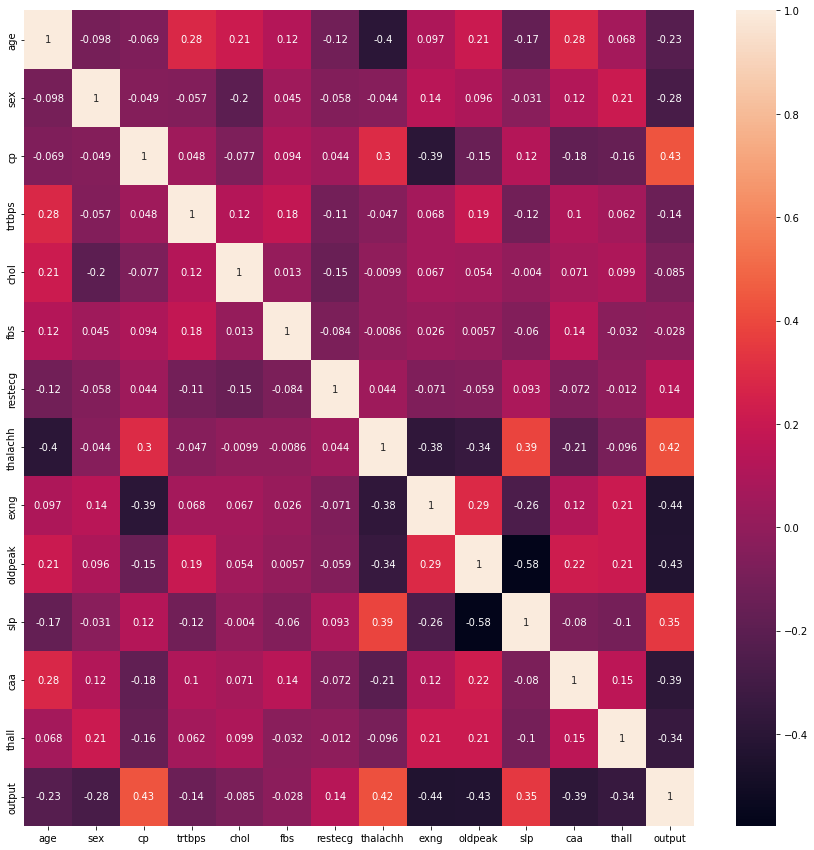

In [14]:
plt.figure(figsize=(15,15))
hm = sns.heatmap(df.corr(), xticklabels=True,yticklabels=True,annot=True)
plt.show()

In [15]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [12]:
y = df.pop('output')

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(df,y, test_size=0.25, random_state=0)
print([xtrain.shape,ytrain.shape,xtest.shape,ytest.shape])

[(227, 13), (227,), (76, 13), (76,)]


In [4]:
categorical_columns = ['sex','cp','fbs','restecg','exng','slp','caa','thall']
numeric_columns = ['trtbps','chol','thalachh','oldpeak']
feat_cols = []
for x in categorical_columns:
    vocabulary = df[x].unique()
    feat_cols.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(x,vocabulary)))
for x in numeric_columns:
    feat_cols.append(tf.feature_column.numeric_column(x,dtype = tf.float32))
age = tf.feature_column.numeric_column("age")
age_buckets = tf.feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feat_cols.append(age_buckets)
print(feat_cols)

[IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=(1, 0), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='cp', vocabulary_list=(3, 2, 1, 0), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fbs', vocabulary_list=(1, 0), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='restecg', vocabulary_list=(0, 1, 2), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='exng', vocabulary_list=(0, 1), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='slp', vocabulary_list=(0, 2, 1), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=Vocabu

In [23]:
def make_input_function(data_df, label_df, num_epochs = 20, shuffle = True, batch_size = 32):
    def input_func():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_func
train_input_func = make_input_function(xtrain, ytrain)
test_input_func = make_input_function(xtest, ytest, num_epochs=1, shuffle=False)

In [27]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feat_cols)
linear_est = linear_est.train(train_input_func)
result = linear_est.evaluate(test_input_func)
print(result['accuracy'])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\ASUS\\AppData\\Local\\Temp\\tmptf20gjnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into C:\Users\ASUS\AppData\Local\Temp\tmptf20gjnn\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 0.6931472, step = 0
INFO:tensorflow:global_step/sec: 189.38
INFO:tensorflow:loss = 0.3980875, step = 100 (0.530 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 160...
INFO:tensorflow:Saving checkpoints for 160 into C:\Users\ASUS\AppData\Local\Temp\tmptf20gjnn\model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 160...
INFO:tensorflow:Loss for final step: 0.31434366.
INFO:tensorflow:Calling model_fn.


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_estimator\python\estimator\canned\linear.py:1468: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self.bias = self.add_variable(


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2023-02-11T17:09:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\ASUS\AppData\Local\Temp\tmptf20gjnn\model.ckpt-160
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 1.17609s
INFO:tensorflow:Finished evaluation at 2023-02-11-17:09:39
INFO:tensorflow:Saving dict for global step 160: accuracy = 0.59210527, accuracy_baseline = 0.56578946, auc = 0.78787875, auc_precision_recall = 0.75438595, average_loss = 2.139879, global_step = 160, label/mean = 0.56578946, loss = 2.4154732, precision = 0.5810811, prediction/mean = 0.9461167, recall = 1.0
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 160: C:\Users\ASUS\AppData\Local\Temp\tmptf20gjnn\model.ckpt-160
0.59210527


In [19]:
#pickle.dump(linear_est, open('lin_est.pkl', 'wb'))
joblib.dump(linear_est, 'lin_est.pkl')

PicklingError: Can't pickle <function LinearClassifierV2.__init__.<locals>._model_fn at 0x000001B313C9F400>: it's not found as tensorflow_estimator.python.estimator.canned.linear.LinearClassifierV2.__init__.<locals>._model_fn

In [6]:
#Ann model sathi
def df_to_dataset(dataframe, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('output')
    return tf.data.Dataset.from_tensor_slices((dict(dataframe), labels)).shuffle(buffer_size = len(dataframe)).batch(batch_size)
train_input_func = df_to_dataset(train)
test_input_func = df_to_dataset(test)

In [8]:
feature_layer = tf.keras.layers.DenseFeatures(feat_cols)

In [35]:
model = tf.keras.models.Sequential([
    feature_layer,
    tf.keras.layers.Dense(units = 128, activation = 'relu'),
    tf.keras.layers.Dropout(rate=0.1),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [36]:
model.compile(optimizer='adam',
              loss= 'binary_crossentropy',
              metrics=['accuracy'])

In [37]:
history = model.fit(train_input_func, validation_data=test_input_func, epochs=100, use_multiprocessing=True)
model.evaluate(test_input_func)

Epoch 1/100
8/8 [==============================] - 3s 67ms/step - loss: 0.0000e+00 - accuracy: 0.4752 - val_loss: 0.0000e+00 - val_accuracy: 0.4918
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4463 - val_loss: 0.0000e+00 - val_accuracy: 0.4918
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4463 - val_loss: 0.0000e+00 - val_accuracy: 0.4918
Epoch 4/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4463 - val_loss: 0.0000e+00 - val_accuracy: 0.4918
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.4463 - val_loss: 0.0000e+00 - val_accuracy: 0.4918
Epoch 6/100
8/8 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.4463 - val_loss: 0.0000e+00 - val_accuracy: 0.4918
Epoch 7/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 0.4463 - val_loss: 0.0

[0.0, 0.49180328845977783]